Summary

1. Process data: drop columns with many nans; normalize ignoring nan vals; fill in nans with zeros (mean); drop highly correlated variables; build polynomial (degree 2 or 3); normalize again; add offset
2. Try ridge regression -> pretty good results, but not the best for classification
3. Try logistic regression -> we might be overfitting
4. Try an improved regularized logistic regression: doesnt penalize the mean component, and has an adaptive lambda. This is better for convergence (SGD), we dont worry about w0 being penalized (there are more labels of one kind than of the other, thus the mean of y is not 0, but we don't want to penalize it).

# General

In [1]:
# run.py
import numpy as np
import matplotlib.pyplot as plt 
from proj1_helpers import *
from auxiliary_functions import *
%matplotlib inline

In [2]:
def calculate_precision(y, y_pred, zeros_ones=False):
    if len(np.array(y).shape) > 1:
        y=y.flatten()
    if len(np.array(y_pred).shape) > 1:
        y_pred=y_pred.flatten()
    if zeros_ones:
        incorrect = np.sum(np.abs(y - y_pred))
    else:
        incorrect = np.sum(np.abs(y - y_pred))/2
    precision = 1 - (incorrect / y.shape[0])
    return precision

def predict_labels_bis(weights, data, return_zeros=False):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    if return_zeros:
        y_pred[np.where(y_pred <= 0.5)] = 0
    else:
        y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1

    return y_pred

In [3]:
DATA_PATH = '../data/'

#### Read files and prepare data

In [5]:
# read files and prepare data
yb, input_data, ids = load_csv_data(DATA_PATH+'train.csv')
test_yb, test_input_data, test_ids = load_csv_data(DATA_PATH+'test.csv')

# Y contains two arrays, one with labels -1 and 1, other with 0 and 1
y = np.ones(len(yb))
y[np.where(yb==-1)] = 0
Y=np.array((yb, y)).T

# keep fullest columns only
nans=[]
for c in input_data.T:
    nans.append(-c[np.where(c==-999)].sum()/999)
cols_full = np.array(range(input_data.shape[1]))[np.where(np.array(nans) < 40000)]
full_data = input_data[:, cols_full]
test_full_data = test_input_data[:, cols_full]

#### Normalize over normal values

In [6]:
def standardize_test(x, means, stds):
    x_1 = x - means
    x_2 = x_1 / stds
    return x_2

In [7]:
def standardize_ignoring_values(x, nan):
    cs=[]
    means=[]
    stds=[]
    for c in x.T:
        mean = np.mean(c[np.where(c!=nan)])
        c_1 = c - mean
        std = np.std(c_1[np.where(c!=nan)])
        c_2 = c_1 / std
        c_2[np.where(c==nan)]=0
        means.append(mean)
        stds.append(std)
        cs.append(c_2)
    return np.array(cs).T, np.array(means), np.array(stds)

In [8]:
def standardize_test_ignoring_values(x, nan, means, stds):
    x_1 = x - means
    x_2 = x_1 / stds
    x_2[np.where(x==nan)]=0
    return x_2

#### Check correlation matrix

In [9]:
def corr_matrix(x):
    corrs=[]
    for i in range(x.shape[1]):
        corr_row = []
        for j in range(x.shape[1]):
            corr = np.corrcoef(x[:,i], x[:,j])[0,1]
            corr_row.append(corr)
        corrs.append(corr_row)
    return np.array(corrs)

In [10]:
np.delete([1,2,3], 1)

array([1, 3])

In [11]:
def remove_highly_correlated(x, val_max):
    x_corr = corr_matrix(x)
    low_correlated = []
    to_be_removed = []
    for r in range(x_corr.shape[0]):
        to_compare = abs(x_corr[r,:r])
        to_compare_e = []
        to_compare_c = []
        low_corr = True
        if len(to_compare) > 0:
            for i in range(len(to_compare)):
                if i not in to_be_removed:
                    to_compare_c.append(to_compare[i])
                    to_compare_e.append(i)
            if np.array(to_compare_c).max() > val_max:
                low_corr = False
                to_be_removed.append(r)
        low_correlated.append(low_corr)
    return low_correlated

In [12]:
x, mean_x, std_x = standardize_ignoring_values(full_data, -999)
test_x = standardize_test_ignoring_values(test_full_data, -999, mean_x, std_x)

cols_useful = np.array(range(len(cols_full)))[np.where(remove_highly_correlated(x, .75))]
small_x = x[:, cols_useful]
test_small_x = test_x[:, cols_useful]

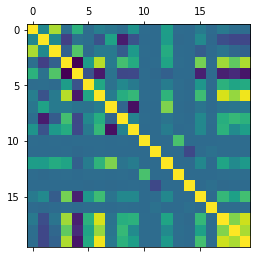

In [13]:
plt.matshow(corr_matrix(x))

#### Build poly

#### Build poly, Standardize again, add offset (only used for the improved regularized logistic regression, which is currently the top submission)

In [14]:
poly_tx_1 = build_poly(small_x, 3, offset=False)
test_poly_tx_1 = build_poly(test_small_x, 3, offset=False)

x2, mean_x2, std_x2 = standardize(poly_tx_1)
test_x2 = standardize_test(test_poly_tx_1, mean_x2, std_x2)

yb, poly_tx = build_model_data(x2, yb)
test_yb, test_poly_tx = build_model_data(test_x2, test_yb)

#### Split data: 80% for training and 20% for testing. Out of the training, 80% is for *training* and 20% for validation

In [15]:
tv_tx, te_tx, tv_Y, te_Y = split_data(poly_tx, Y, .8)

In [16]:
tr_tx, va_tx, tr_Y, va_Y = split_data(tv_tx, tv_Y, .8)

# Ridge regression

In [ ]:
from implementations import ridge_regression

In [ ]:
tr_y = tr_Y.T[0]
va_y = va_Y.T[0]
te_y = te_Y.T[0]

In [ ]:
tr_errors = []
va_errors = []
ws = []

lambdas = np.logspace(-2, 5, num=30)

for lambda_ in lambdas:
    w, loss = ridge_regression(tr_y, tr_tx, lambda_)
    tr_y_pred = predict_labels(w, tr_tx)
    va_y_pred = predict_labels(w, va_tx)
    tr_error = 1 - calculate_precision(tr_y, tr_y_pred)
    va_error = 1 - calculate_precision(va_y, va_y_pred)
    ws.append(w)
    tr_errors.append(tr_error)
    va_errors.append(va_error)

In [ ]:
plt.semilogx(lambdas, tr_errors)
plt.semilogx(lambdas, va_errors)
plt.show()

We can choose $\lambda=10^{2}$

In [ ]:
lambda_ = 1e2
w, loss = ridge_regression(tr_y, tr_tx, lambda_)
te_y_pred = predict_labels(w, te_tx)
calculate_precision(te_y_pred, te_y)

0.75263999999999998

Get submission:

In [ ]:
test_y_pred = predict_labels(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'1_ridge_fd.csv')

# Logistic Regression

In [ ]:
from implementations import logistic_regression

In [ ]:
np.random.seed(1)

In [ ]:
tr_y = tr_Y.T[1]
va_y = va_Y.T[1]
te_y = te_Y.T[1]

In [ ]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 20
ws = []
losses = []
tr_errors = []
va_errors = []
gammas = np.logspace(-8, -3.3, 12)
for gamma in gammas:
    w, loss = logistic_regression(tr_y, tr_tx, initial_w, max_iters, gamma)
    tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
    va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
    tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
    va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
    tr_errors.append(tr_error)
    print(tr_error)
    va_errors.append(va_error)
    print(va_error)
    ws.append(w)
    losses.append(loss)

In [ ]:
gammas

In [ ]:
plt.semilogx(gammas, tr_errors)
plt.semilogx(gammas, va_errors)
plt.show()

Final choice:

In [ ]:
np.random.seed(1)

In [ ]:
gamma = 10**-3.3
max_iters = 80
initial_w = np.zeros((tr_tx.shape[1], 1))
w, loss = logistic_regression(tr_y, tr_tx, initial_w, max_iters, gamma)

Test it

In [ ]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

0.76563999999999999

Get submission:

In [ ]:
test_y_pred = predict_labels_bis(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'2_lr.csv')

# Logistic Regression with adaptive lambda

In [ ]:
np.random.seed(1)

tr_y = tr_Y.T[1]
va_y = va_Y.T[1]
te_y = te_Y.T[1]

In [ ]:
def logistic_regression_improved(y, tx, initial_w, max_iters, gamma,
    batch_size=1000, return_all=False):
    """Logistic regression, with adaptive lambda"""
    if len(tx.shape) == 1:
        tx = tx.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    initial_w = np.array(initial_w).reshape(tx.shape[1], 1)
    
    # init parameters    
    w = initial_w
    if return_all:
        ws = [w]
        losses = []

    for n_iter in range(max_iters):
        # get mini-batch
        y_n, tx_n = get_batch(y, tx, batch_size)
        # get loss and update w by gradient
        loss, w = logistic_by_gd(y_n, tx_n, w, next(gamma))
        if return_all:
            # store w and loss
            ws.append(w)
            losses.append(loss)
            if n_iter % 100 == 0:
                print("Current iteration={i}, loss={l}".format(i=n_iter, l=loss))
    # return w and loss, either all or only last ones
    if return_all:
        return ws, losses
    else:
        return w, loss

In [ ]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 40
ws = []
losses = []
tr_errors = []
va_errors = []

gammas = [(np.random.uniform(.1,.9), np.random.randint(-4,-2)) for k in range(20)]

for g in gammas:
    gamma = adaptive_gamma(kappa=g[0], eta0=10**g[1])
    w, loss = logistic_regression_improved(tr_y, tr_tx, initial_w, max_iters, gamma)
    tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
    va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
    tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
    va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
    tr_errors.append(tr_error)
    va_errors.append(va_error)
    ws.append(w)
    losses.append(loss)

In [ ]:
gammas

In [ ]:
tr_errors

In [ ]:
va_errors

Final choice:

In [ ]:
np.random.seed(1)

In [ ]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 100
gamma = adaptive_gamma(kappa=0.1, eta0=1e-3)
w, loss = logistic_regression_improved(tr_y, tr_tx, initial_w, max_iters, gamma, batch_size=1000)

Test it

In [ ]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

0.77025999999999994

Submission:

In [ ]:
test_y_pred = predict_labels_bis(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'3_lri.csv')

# Regularized logistic regression

In [ ]:
np.random.seed(1)

tr_y = tr_Y.T[1]
va_y = va_Y.T[1]
te_y = te_Y.T[1]

In [ ]:
from implementations import reg_logistic_regression

Check different gammas and lambdas:

In [ ]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 60
ws=[]
tr_errors=[]
te_errors=[]
losses = []

gammas = np.logspace(-4, -3, 3)
lambdas = np.logspace(-4, 0, num=5)

for gamma in gammas:
    for lambda_ in lambdas:
        w, loss = reg_logistic_regression(tr_y, tr_tx, lambda_, initial_w, max_iters, gamma, batch_size=2000)        
        tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
        va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
        tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
        va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
        tr_errors.append(tr_error)
        va_errors.append(va_error)
        print()
        print(gamma)
        print(lambda_)
        print(va_error)
        
        ws.append(w)
        losses.append(loss)

Final choice:

In [ ]:
np.random.seed(1)

gamma = .001
lambda_ = .01
max_iters = 100
initial_w = np.zeros((tr_tx.shape[1], 1))
w, loss = reg_logistic_regression(tr_y, tr_tx, lambda_, initial_w, max_iters,
    gamma, batch_size=2000)

Test it:

In [ ]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

# Improved regularized logistic regression with adaptive gamma

In [24]:
np.random.seed(1)

tr_y = tr_Y.T[1]
va_y = va_Y.T[1]
te_y = te_Y.T[1]

In [21]:
def reg_logistic_regression_improved(y, tx, lambda_, initial_w, max_iters,
    gamma, batch_size=1000, return_all=False):
    """Regularized logistic regression using mini-batch gradient descent.
    Uses adaptive lambda and does not penalize offset."""
    if len(tx.shape) == 1:
        tx = tx.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    initial_w = np.array(initial_w).reshape(tx.shape[1], 1)

    # init parameters
    w = initial_w
    if return_all:
        ws = [w]
        losses = []

    for n_iter in range(max_iters):
        # get mini-batch
        y_n, tx_n = get_batch(y, tx, batch_size)
        # get loss and update w by gradient
        loss, w = reg_logistic_by_gd(y_n, tx_n, lambda_, w, next(gamma), False)
        if return_all:
            # store w and loss
            ws.append(w)
            losses.append(loss)
            if n_iter % 100 == 0:
                print("Current iteration={i}, loss={l}".format(i=n_iter, l=loss))
    # return w and loss, either all or only last ones
    if return_all:
        return ws, losses
    else:
        return w, loss

Check different gammas and lambdas:

In [25]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 50
ws=[]
tr_errors=[]
va_errors=[]
losses = []

gammas = [(np.random.uniform(.05,.9), np.random.randint(-4,-1)) for k in range(10)]
lambdas = np.logspace(-3, 3, num=7)

for g in gammas:
    for lambda_ in lambdas:
        gamma = adaptive_gamma(kappa=g[0], eta0=10**g[1])
        w, loss = reg_logistic_regression_improved(tr_y, tr_tx, lambda_, initial_w, max_iters, gamma)        
        tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
        va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
        tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
        va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
        tr_errors.append(tr_error)
        va_errors.append(va_error)
        print()
        print(lambda_)
        print(g)
        print(va_error)
        
        ws.append(w)
        losses.append(loss)


0.001
(0.4044687039971879, -4)
0.28295

0.01
(0.4044687039971879, -4)
0.28315

0.1
(0.4044687039971879, -4)
0.283175

1.0
(0.4044687039971879, -4)
0.2835

10.0
(0.4044687039971879, -4)
0.28315

100.0
(0.4044687039971879, -4)
0.284775

1000.0
(0.4044687039971879, -4)
0.323575

0.001
(0.84267375543786, -3)
0.261375

0.01
(0.84267375543786, -3)
0.2615

0.1
(0.84267375543786, -3)
0.259425

1.0
(0.84267375543786, -3)
0.261375

10.0
(0.84267375543786, -3)
0.261425

100.0
(0.84267375543786, -3)
0.268075

1000.0
(0.84267375543786, -3)
0.317625

0.001
(0.3069826867370638, -4)
0.2808

0.01
(0.3069826867370638, -4)
0.280675

0.1
(0.3069826867370638, -4)
0.279375

1.0
(0.3069826867370638, -4)
0.280125

10.0
(0.3069826867370638, -4)
0.280625

100.0
(0.3069826867370638, -4)
0.280825

1000.0
(0.3069826867370638, -4)
0.319775

0.001
(0.12848780555347813, -4)
0.273375

0.01
(0.12848780555347813, -4)
0.27335

0.1
(0.12848780555347813, -4)
0.272225

1.0
(0.12848780555347813, -4)
0.2741

10.0
(0.12848780

/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:106: RuntimeWarning: overflow encountered in exp
  loss = (np.sum(np.log(1 + np.exp(tx_w))) - np.sum(y * tx_w) +
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:118: RuntimeWarning: overflow encountered in exp
  t_exp = np.exp(t)
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:119: RuntimeWarning: invalid value encountered in true_divide
  return t_exp / (t_exp + 1)
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater



1000.0
(0.3872523530960694, -2)
nan

0.001
(0.7693642791831146, -3)
0.2586

0.01
(0.7693642791831146, -3)
0.25895

0.1
(0.7693642791831146, -3)
0.258775


KeyboardInterrupt: 

Final choice:

In [26]:
np.random.seed(1)

initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 100
gamma = adaptive_gamma(kappa=0.4, eta0=1e-2)
lambda_= .001
w, loss = reg_logistic_regression_improved(tr_y, tr_tx, lambda_, initial_w,
                                           max_iters, gamma)

Test it:

In [27]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

0.76863999999999999

0.76863999999999999 (Using 3 degrees)

In [28]:
test_y_pred = predict_labels_bis(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'5_irlr_5.csv')

# Cross validation

Ridge regression using k-fold

In [29]:
def build_k_indices(y, k_fold, seed):
    '''
    Build k indices for k-fold.
    '''
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def split_data_k_indices(y, x, k_indices, k):
    '''
    Splits the data into test and training data.
    Samples get randomized through 'k_indices' and
    selected through 'k'.
    '''
    mask = np.ones(k_indices.shape, dtype=bool)
    mask[k] = False
    
    # Test data
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    
    # Train data
    x_train = x[k_indices[mask]]
    y_train = y[k_indices[mask]]
    
    return x_test, y_test, x_train, y_train

In [30]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    '''
    Return the loss of ridge regression.
    '''
    # Split data according to 'k_indices' and 'k'
    x_test, y_test, x_train, y_train = split_data_k_indices(y, x, k_indices, k)

    # Form data with polynomial degree
    # tx_test = build_poly(x_test, degree)
    # tx_train = build_poly(x_train, degree)

    # Apply ridge regression
    w_opt, rmse_train = ridge_regression(y_train, x_train, lambda_)
    
    prediction = {
        'train': predict_labels(w_opt, x_train),
        'test': predict_labels(w_opt, x_test)
    } 
    
    precision = {
        'train': calculate_precision(prediction['train'], y_train),
        'test': calculate_precision(prediction['test'], y_test)
    }
    
    # Return loss for train and test data
    return precision['train'], precision['test']

In [31]:
def cross_validation_visualization(lambds, mse_tr, mse_te, mse_dif):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.semilogx(lambds, mse_dif, marker=".", color='y', label='error delta')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

In [ ]:
degree = 7
k_fold = 3
seed = 13

lambdas = np.logspace(-40, 40, 30)

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)

lambda_avg_rmse_trs = []
lambda_avg_rmse_tes = []
lambda_avg_rmse_difs = []

for lambda_ in lambdas:
    
    rmse_trs = []
    rmse_tes = []
    rmse_difs = []

    # K-fold cross validation and pick the rmse 'test' and 'train'
    # errors that represent the least absolute difference between
    # them (for a given lambda).
    for k in range(k_fold):
        rmse_cur_tr, rmse_cur_te = cross_validation(y, x, k_indices, k, lambda_, degree)
        
        rmse_trs.append(rmse_cur_tr)
        rmse_tes.append(rmse_cur_te)
        rmse_difs.append(abs(rmse_cur_tr - rmse_cur_te))
        
    lambda_avg_rmse_trs.append(np.mean(rmse_trs))
    lambda_avg_rmse_tes.append(np.mean(rmse_tes))
    lambda_avg_rmse_difs.append(np.mean(rmse_difs))

cross_validation_visualization(lambdas, lambda_avg_rmse_trs, lambda_avg_rmse_tes, lambda_avg_rmse_difs)

# Try cross validation in reg logistic regression (TODO)

In [34]:
def cross_validation_rlr(y, x, k_indices, k, lambda_, gamma):
    '''
    Return the loss of ridge regression.
    '''
    # Split data according to 'k_indices' and 'k'
    x_test, y_test, x_train, y_train = split_data_k_indices(y, x, k_indices, k)

    # Apply ridge regression
    w_opt, rmse_train = w, loss = reg_logistic_regression_improved(y_train, x_train, lambda_, initial_w, 100, gamma)

    prediction = {
        'train': predict_labels_bis(w_opt, x_train, return_zeros=True),
        'test': predict_labels_bis(w_opt, x_test, return_zeros=True)
    } 
    
    precision = {
        'train': 1 - calculate_precision(prediction['train'], y_train, zeros_ones=True),
        'test': 1 - calculate_precision(prediction['test'], y_test, zeros_ones=True),
    }
    
    # Return loss for train and test data
    return precision['train'], precision['test']

In [37]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 100
ws=[]
tr_errors=[]
va_errors=[]
losses = []
k_fold=3
seed=1

yc=Y[1]
xc=poly_tx

# split data in k fold
k_indices = build_k_indices(yc, k_fold, seed)

lambda_gamma_avg_rmse_trs = []
lambda_gamma_avg_rmse_tes = []
lambda_gamma_avg_rmse_difs = []

np.random.seed(1)
gammas = [(np.random.uniform(.05,.9), np.random.randint(-4,-1)) for k in range(20)]
lambdas = np.logspace(-4, 4, num=9)

for g in gammas:
    for lambda_ in lambdas:
        rmse_trs = []
        rmse_tes = []
        rmse_difs = []
        for k in range(k_fold):
            gamma = adaptive_gamma(kappa=g[0], eta0=10**g[1])
            rmse_cur_tr, rmse_cur_te = cross_validation_rlr(yc, xc, k_indices, k, lambda_, gamma)
            rmse_trs.append(rmse_cur_tr)
            rmse_tes.append(rmse_cur_te)
            rmse_difs.append(abs(rmse_cur_tr - rmse_cur_te))
        lambda_gamma_avg_rmse_trs.append(np.mean(rmse_trs))
        lambda_gamma_avg_rmse_tes.append(np.mean(rmse_tes))
        lambda_gamma_avg_rmse_difs.append(np.mean(rmse_difs))

/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:72: RuntimeWarning: invalid value encountered in double_scalars
  return z[0][0] / tx.shape[0]
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


In [38]:
lambda_gamma_avg_rmse_trs

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

Read test data

In [ ]:
test_yb, test_input_data, test_ids = load_csv_data(DATA_PATH+'test.csv')

Predict labels:

In [ ]:
test_y_pred = predict_labels(w_opt, test_input_data)

Create submission:

In [ ]:
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'submission.csv')